<a href="https://colab.research.google.com/github/danielwhitt/FATE/blob/main/parcels_quickstart_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install parcels
!pip install cftime
!pip install cgen
!pip install trajan
!pip install zarr
!pip install pymbolic

import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymbolic: filename=pymbolic-2022.2-py3-none-any.whl size=127319 sha256=94b65d077a0eb484d0a81d4d2b90a8d19e4413cc8fb9b601e1e6d3a71c12b024
  Stored in directory: /root/.cache/pip/wheels/c5/5e/88/b7f04b19af22919fcc93dbdaac8b755ba83bba22ad27e905ec
Successfully built pymbolic


In [23]:
example_dataset_folder = download_example_dataset("MovingEddies_data")

fieldset = FieldSet.from_parcels(f"{example_dataset_folder}/moving_eddies")

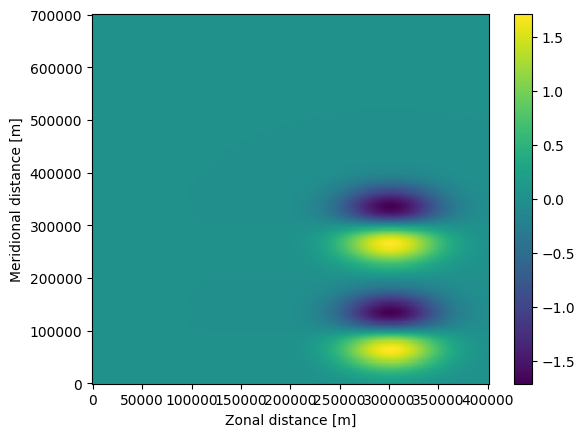

In [24]:
fieldset.computeTimeChunk()

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.show()


In [25]:
pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=[3.3e5, 3.3e5],  # a vector of release longitudes
    lat=[1e5, 2.8e5],  # a vector of release latitudes
)


In [26]:
print(pset)


P[2](lon=330000.000000, lat=100000.000000, depth=0.000000, time=not_yet_set)
P[3](lon=330000.000000, lat=280000.000000, depth=0.000000, time=not_yet_set)


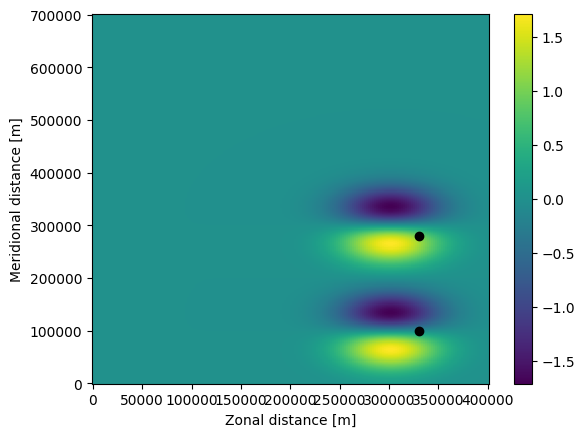

In [27]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()


In [28]:
output_file = pset.ParticleFile(
    name="EddyParticles.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=6),  # the total length of the run
    dt=timedelta(minutes=5),  # the timestep of the kernel
    output_file=output_file,
)


INFO: Output files are stored in EddyParticles.zarr.


INFO:parcels.tools.loggers:Output files are stored in EddyParticles.zarr.


100%|██████████| 518400.0/518400.0 [00:03<00:00, 133734.94it/s]


P[2](lon=226905.562500, lat=82515.218750, depth=0.000000, time=518100.000000)
P[3](lon=260835.125000, lat=320403.343750, depth=0.000000, time=518100.000000)


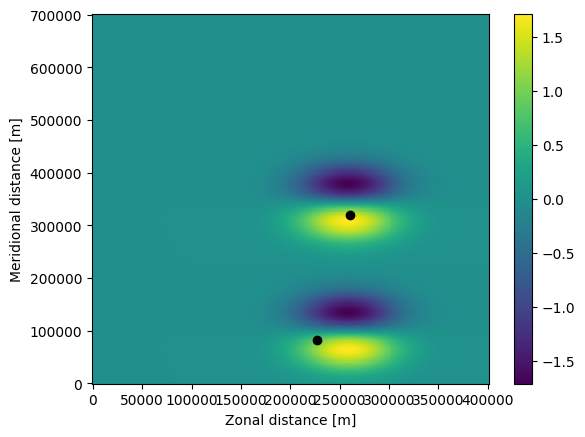

In [29]:
print(pset)

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()


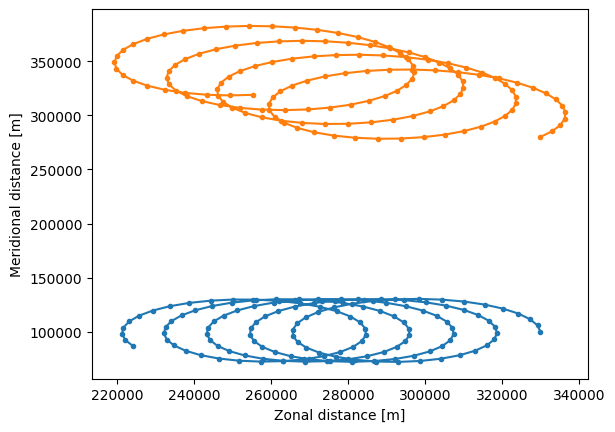

In [30]:
ds = xr.open_zarr("EddyParticles.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.show()


In [31]:
%%capture
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 4e5)
ax.set_ylim(0, 7e5)

# show only every fifth output (for speed in creating the animation)
timerange = np.unique(ds["time"].values)[::5]

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)


In [32]:
HTML(anim.to_jshtml())


In [33]:
output_file = pset.ParticleFile(
    name="EddyParticles_Bwd.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4,
    dt=-timedelta(minutes=5),  # negative timestep for backward run
    runtime=timedelta(days=6),  # the run time
    output_file=output_file,
)


INFO: Output files are stored in EddyParticles_Bwd.zarr.


INFO:parcels.tools.loggers:Output files are stored in EddyParticles_Bwd.zarr.


100%|██████████| 518400.0/518400.0 [00:08<00:00, 63045.98it/s] 


P[2](lon=329983.281250, lat=100495.609375, depth=0.000000, time=300.000000)
P[3](lon=330289.968750, lat=280418.906250, depth=0.000000, time=300.000000)


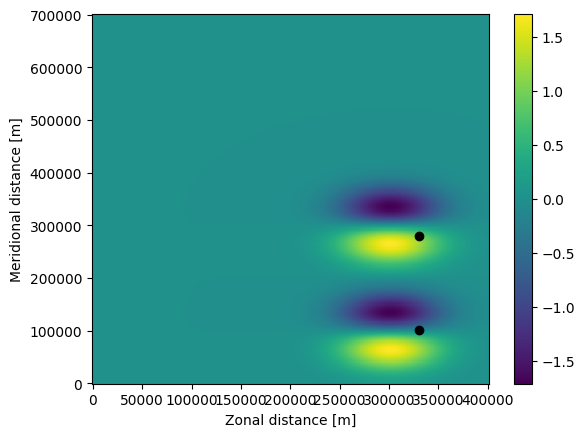

In [34]:
print(pset)

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()


In [35]:
def WestVel(particle, fieldset, time):
    if time > 86400:
        uvel = -2.0
        particle_dlon += uvel * particle.dt


In [36]:
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=JITParticle, lon=[3.3e5, 3.3e5], lat=[1e5, 2.8e5]
)

output_file = pset.ParticleFile(
    name="EddyParticles_WestVel.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    [AdvectionRK4, WestVel],  # simply combine the Kernels in a list
    runtime=timedelta(days=2),
    dt=timedelta(minutes=5),
    output_file=output_file,
)


INFO: Output files are stored in EddyParticles_WestVel.zarr.


INFO:parcels.tools.loggers:Output files are stored in EddyParticles_WestVel.zarr.


100%|██████████| 172800.0/172800.0 [00:01<00:00, 138340.66it/s]


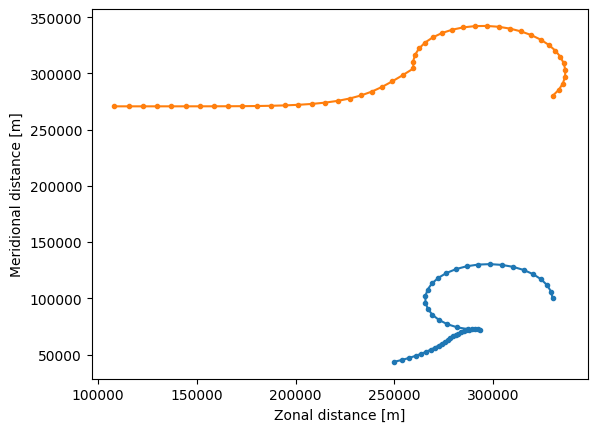

In [37]:
ds = xr.open_zarr("EddyParticles_WestVel.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.show()


In [38]:
example_dataset_folder = download_example_dataset("GlobCurrent_example_data")

filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}


In [39]:
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}


In [40]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)


In [41]:
pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=5,  # releasing 5 particles
    start=(28, -33),  # releasing on a line: the start longitude and latitude
    finish=(30, -33),  # releasing on a line: the end longitude and latitude
)


In [42]:
output_file = pset.ParticleFile(
    name="GlobCurrentParticles.zarr", outputdt=timedelta(hours=6)
)
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)


INFO: Output files are stored in GlobCurrentParticles.zarr.


INFO:parcels.tools.loggers:Output files are stored in GlobCurrentParticles.zarr.


100%|██████████| 864000.0/864000.0 [00:01<00:00, 771266.44it/s]


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhs/latest/gshhg-shp-2.3.7.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


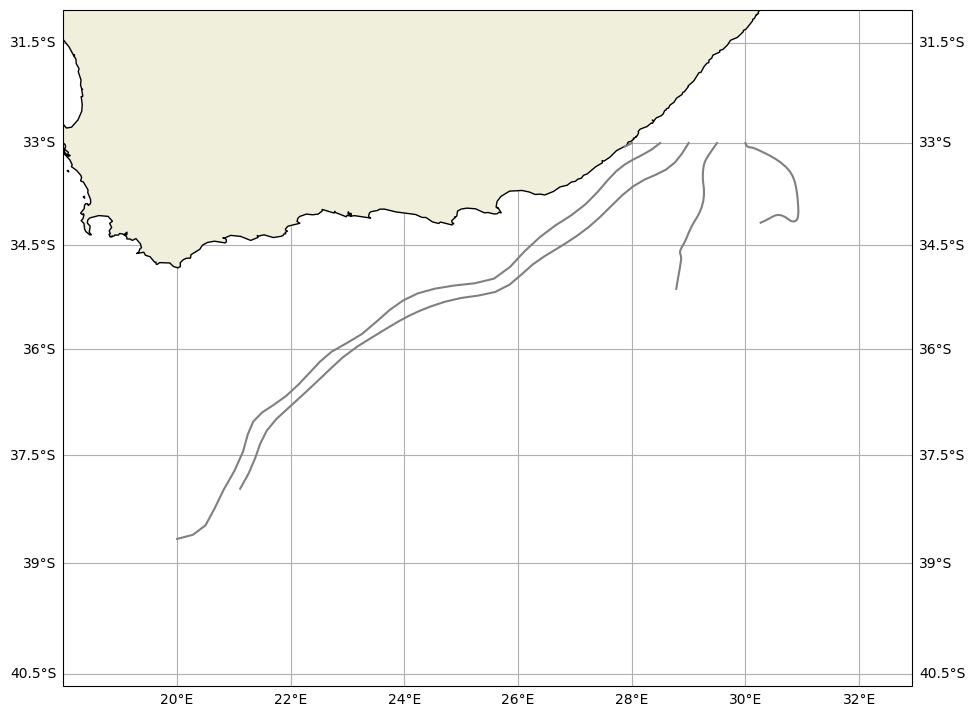

In [43]:
ds = xr.open_zarr("GlobCurrentParticles.zarr")
ds.traj.plot(margin=2)
plt.show()


In [44]:
example_dataset_folder = download_example_dataset("Peninsula_data")
fieldset = FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula",
    extra_fields={"P": "P"},
    allow_time_extrapolation=True,
)


In [45]:
SampleParticle = JITParticle.add_variable("p")

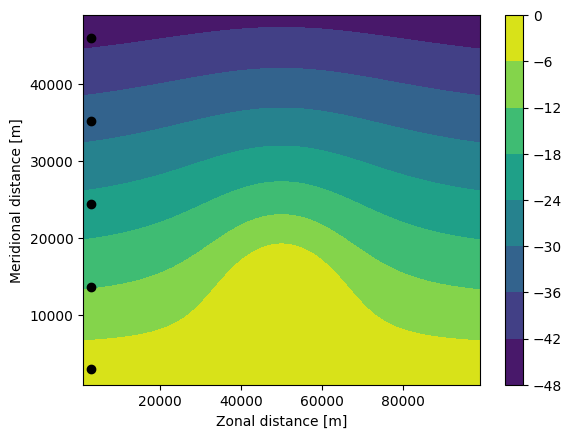

In [46]:
pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=SampleParticle,
    start=(3000, 3000),
    finish=(3000, 46000),
    size=5,
    time=0,
)

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()


In [47]:
def SampleP(particle, fieldset, time):
    """Custom function that samples fieldset.P at particle location"""
    particle.p = fieldset.P[time, particle.depth, particle.lat, particle.lon]


In [48]:
output_file = pset.ParticleFile(
    name="PeninsulaPressure.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    [AdvectionRK4, SampleP],  # list of kernels to be executed
    runtime=timedelta(hours=20),
    dt=timedelta(minutes=5),
    output_file=output_file,
)


INFO: Output files are stored in PeninsulaPressure.zarr.


INFO:parcels.tools.loggers:Output files are stored in PeninsulaPressure.zarr.


100%|██████████| 72000.0/72000.0 [00:00<00:00, 125995.70it/s]


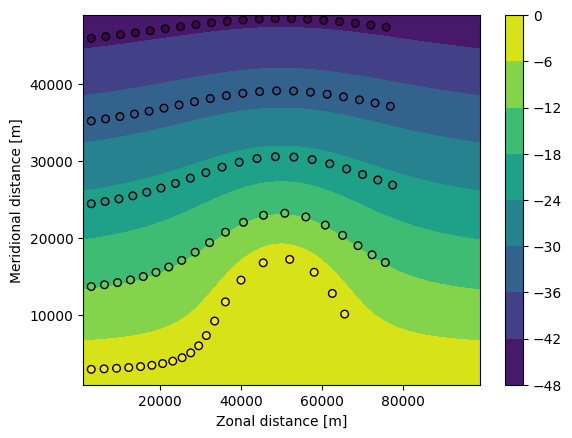

In [49]:
ds = xr.open_zarr("PeninsulaPressure.zarr")

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.scatter(ds.lon, ds.lat, c=ds.p, s=30, cmap="viridis", edgecolors="k")
plt.show()


In [50]:
extra_vars = [
    Variable("distance", initial=0.0, dtype=np.float32),
    Variable("prev_lon", dtype=np.float32, to_write=False, initial=attrgetter("lon")),
    Variable("prev_lat", dtype=np.float32, to_write=False, initial=attrgetter("lat")),
]

DistParticle = JITParticle.add_variables(extra_vars)


In [51]:
def TotalDistance(particle, fieldset, time):
    """Calculate the distance in latitudinal direction
    (using 1.11e2 kilometer per degree latitude)"""
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    lon_dist = (
        (particle.lon - particle.prev_lon)
        * 1.11e2
        * math.cos(particle.lat * math.pi / 180)
    )
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    # Set the stored values for next iteration
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat


In [52]:
example_dataset_folder = download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
pset = ParticleSet.from_line(
    fieldset=fieldset, pclass=DistParticle, size=5, start=(28, -33), finish=(30, -33)
)


In [53]:
pset.execute(
    [AdvectionRK4, TotalDistance],  # list of kernels to be executed
    runtime=timedelta(days=6),
    dt=timedelta(minutes=5),
    output_file=pset.ParticleFile(
        name="GlobCurrentParticles_Dist.zarr", outputdt=timedelta(hours=1)
    ),
)


INFO: Output files are stored in GlobCurrentParticles_Dist.zarr.


INFO:parcels.tools.loggers:Output files are stored in GlobCurrentParticles_Dist.zarr.


100%|██████████| 518400.0/518400.0 [00:07<00:00, 72696.39it/s]


In [54]:
print([p.distance for p in pset])


[13.197482, 640.92773, 543.45953, 183.60716, 172.74182]
